# Deep Galerkin Method - Black-Scholes Equation

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [0]:
tf.random.set_seed(4155)

## Option Model

In [0]:
class OptionModel():


  def __init__(self, direction="C", S=100.0, K=110.0, r=0.02, v=0.2, T=1.0):
    """Constructor for the option model.

    Parameters
    ----------
    direction : str
      Direction of the option, either "C" for call or "P" for put
    S : float
      Initial price of the underlying
    K : float
      Strike price of the option
    r : float
      Risk-free rate
    v : float
      Volatility, i.e. standard deviation of the underlying
    T : float
      Expiry date of the option
    """
    self.direction = direction
    self.S = tf.Variable(S, name="S", dtype=tf.float32)
    self.K = tf.Variable(K, name="K", dtype=tf.float32)
    self.r = tf.Variable(r, name="r", dtype=tf.float32)
    self.v = tf.Variable(v, name="sigma", dtype=tf.float32)
    self.T = tf.Variable(T, name="T", dtype=tf.float32)


  def set_domains(self, S_min=None, S_max=None):
    if not S_max:
      self.S_max = 2 * self.S.numpy()
    if not S_min:
      self.S_min = 0.2 * self.S.numpy()
      
    s_dom = np.linspace(self.S_min, self.S_max, 365)
    t_max = self.T.numpy()
    t_dom = np.linspace(0, t_max, 365)

    T, S = np.meshgrid(t_dom, s_dom)
      
    s = S.ravel()
    t = T.ravel()

    self.s = tf.convert_to_tensor(s[:, None], dtype=tf.float32)
    self.t = tf.convert_to_tensor(t[:, None], dtype=tf.float32)
    self.points = tf.concat([self.t,self.s],1)

## Deep Galerkin Method - Model

For the Deep Galerkin Method we define a model with similar architecture to an LSTM model. 

### Deep Galerkin Layer / LSTM Layer

In [0]:
class DGM_layer(layers.Layer):

  def __init__(self, units=50):
    super(DGM_layer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.U = self.add_weight(name="U", shape=(input_shape[-1], self.units),
                             initializer=tf.initializers.GlorotUniform(),
                             trainable=True)
    self.W = self.add_weight(name="W", shape=(self.units, self.units),
                             initializer=tf.initializers.GlorotUniform(),
                             trainable=True)
    
    self.B = self.add_weight(name="B", shape=(self.units,),
                             initializer=tf.initializers.GlorotUniform(),
                             trainable=True)

  def call(self, X, S):
    return tf.nn.tanh(tf.matmul(X, self.U) + tf.matmul(S, self.W) + self.B)

### Neural Network Model

The model used for the Deep Galerkin Method, using the layer defined above is as follows:

In [0]:
class DGM(Model):
  def __init__(self):
    super(DGM, self).__init__()
    self.S_1 = Dense(50, input_shape= (2,) , activation="tanh")
    self.Z_1 = DGM_layer(50)
    self.G_1 = DGM_layer(50)
    self.R_1 = DGM_layer(50)
    self.H_1 = DGM_layer(50)

    self.Z_2 = DGM_layer(50)
    self.G_2 = DGM_layer(50)
    self.R_2 = DGM_layer(50)
    self.H_2 = DGM_layer(50)

    self.Z_3 = DGM_layer(50)
    self.G_3 = DGM_layer(50)
    self.R_3 = DGM_layer(50)
    self.H_3 = DGM_layer(50)

    self.O = Dense(1)

  def call(self, t, s):
    X = tf.concat([t, s], 1)
    S1 = self.S_1(X)

    Z = self.Z_1(X, S1)
    G = self.G_1(X, S1)
    R = self.R_1(X, S1)
    H = self.H_1(X, S1 * R)
    S = (1 - G) * H + Z * S1

    Z = self.Z_2(X, S)
    G = self.G_2(X, S1)
    R = self.R_2(X, S)
    H = self.H_2(X, S * R)
    S = (1 - G) * H + Z * S

    Z = self.Z_3(X, S)
    G = self.G_3(X, S1)
    R = self.R_3(X, S)
    H = self.H_3(X, S * R)
    S = (1 - G) * H + Z * S

    return self.O(S)


### Training Loss
Since we are not using batches during training, I use the mean loss to store the training loss for each iteration. Then the loss at each training iteration is just equal to the loss defined in the loss function below.

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Optimizer

The authors recommend using the ADAM optimizer.

In [0]:
optimizer = tf.keras.optimizers.Adam()

### Sampling Points


In [0]:
@tf.function
def generate_samples(T_max, S_min, S_max, N_samples=500):
  B1_s = tf.random.uniform((N, 1), minval=S_min, maxval=S_max)
  B1_t = tf.random.uniform((N, 1), minval=0.0, maxval=T_max)
  B1 = tf.concat([B1_t, B1_s], 1)

  B2_s = tf.where(tf.random.uniform((N, 1)) < 0.5, 
                  S_min, 
                  S_max)
  B2_t = tf.random.uniform((N, 1), minval=0.0, maxval=T_max)
  B2 = tf.concat([B2_t, B2_s], 1)

  B3_s = tf.random.uniform((N, 1), minval=S_min, maxval=S_max)
  B3_t = T_max * tf.ones_like(B3_s)
  B3 = tf.concat([B3_t, B3_s], 1)

  return B1, B2, B3

### Option Pay-Off Functions:

The pay-off function for call and put options.

For an American call option, the pay-off is zero whenever the market price of the underlying security is below the strike price K. Thus: $$G^{Call}(S_t, t) = max(S_t - K, 0)$$

For an American put option, the pay-off is zero whenever the market price of the underlying security is greater than the strike price K. Thus:
$$G^{Put}(S_t, t) = max(K - S_t, 0)$$

In [0]:
def G_Call(S, K):
  return tf.maximum(S - K, 0)

def G_Put(S, K):
  return tf.maximum(K - S, 0)

### Loss Function:
The loss function used to train the model.

In [0]:
@tf.function
def Loss(model, option, B1, B2, B3):
  r, v, K = option.r, option.v, option.K
  t, S = B1[:, 0, None], B1[:, 1, None]
  with tf.GradientTape() as d:
    d.watch(t)
    d.watch(S)
    with tf.GradientTape() as d2:
      d2.watch(t)
      d2.watch(S)
      V_hat = model(t, S)
    dV_dt, dV_dS = d2.gradient(V_hat, [t, S])
  d2V_dS2 = d.gradient(dV_dS, S)
  V_eq = dV_dt + r * S * dV_dS + 0.5 * v**2 * S**2 * d2V_dS2 - r * V_hat

  J_1 = tf.reduce_mean(tf.square(V_eq))

  t, S = B2[:, 0, None], B2[:, 1, None]
  
  if option.direction == "C":
    g_func = G_Call
  elif option.direction == "P":
    g_func = G_Put
  else:
    g_func = G_Call
  
  g_hat = g_func(S, K)
  V_boundary = model(t, S)

  J_2 = tf.reduce_mean(tf.square(tf.maximum(g_hat - V_boundary, 0)))

  t, S = B3[:, 0, None], B3[:, 1, None]
  g_terminal = g_func(S, K)
  V_terminal = model(t, S)

  J_3 = tf.reduce_mean(tf.square(V_terminal - g_terminal))
  
  return J_1 + J_2 + J_3

### Training

Run the training. The pre-training filtering of the sampled points at each step is optional with the `filter` flag.

In [0]:
@tf.function
def train_step(model, option, B1, B2, B3, filter=False):
  if filter:
    if option.direction == "C":
      g_func = G_Call
    elif option.direction == "P":
      g_func = G_Put
    else:
      g_func = G_Call

    # Filter samples
    v_hat = model(B1[:, 0, None], B1[:, 1, None])
    g_hat = g_func(B1[:, 1, None], option.K)
    mask = tf.greater(v_hat, g_hat)
    B1 = tf.boolean_mask(B1, mask[:, -1])

    v_hat = model(B2[:, 0, None], B2[:, 1, None])
    g_hat = g_func(B2[:, 1, None], option.K)
    mask = tf.less_equal(v_hat, g_hat)
    B2 = tf.boolean_mask(B2, mask[:, -1])

  with tf.GradientTape() as d:
    estimated_loss = Loss(model, option, B1, B2, B3)
  gradients = d.gradient(estimated_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss([estimated_loss])

## Applications

### American Call Option

Run on an American call option. 

#### Initialize the model:

In [0]:
call_model = DGM()

#### Apple Inc. Call Option

The closing price of Apple on 18.12.2019 was $279.74. For this example, we use the 180 day volatility, [estimated at](https://www.alphaquery.com/stock/AAPL/volatility-option-statistics/180-day/historical-volatility) 23.17%.

To estimate the risk free rate, the [10-year U.S. Treasury rate](https://ycharts.com/indicators/10_year_treasury_rate) is often used. This stood at 1.92% on 18.12.2019. 

The strike price is set at 10% above the market price of $279.74.



In [0]:
s_market = 279.74
volatility = 0.2317
strike = 1.1 * s_market
risk_free_rate = 0.0192

call_option = OptionModel(direction="C", 
                          S=s_market, 
                          K=strike, 
                          r=risk_free_rate, 
                          v=volatility, 
                          T=1.0)

call_option.set_domains()

Run the training with:
- 100 000 iterations
- 1000 samples points at each iteration
- Upper limit for the price: `S_u = 2 * s_market`
- Lower limit for the price `S_l = 0.2 * s_market`
- Stopping time `T_u = 1.0`


In [15]:
num_iter = 100000

T_u = 1.0
S_l = 0.2 * s_market
S_u = 2 * s_market
N = 1000

for i in range(num_iter):
  # Generate samples
  B1, B2, B3 = generate_samples(T_u, S_l, S_u, N)

  # Run training step
  train_step(call_model, call_option, B1, B2, B3)

  
  if i % 1000 == 0:
    template = 'Iteration {}, Loss: {}'
    print(template.format(i, train_loss.result()))

  train_loss.reset_states()

Iteration 0, Loss: 41248.375
Iteration 1000, Loss: 12234.953125
Iteration 2000, Loss: 2755.7705078125
Iteration 3000, Loss: 740.0087280273438
Iteration 4000, Loss: 209.8939971923828
Iteration 5000, Loss: 25.100955963134766
Iteration 6000, Loss: 6.7822465896606445
Iteration 7000, Loss: 3.9453072547912598
Iteration 8000, Loss: 3.5041580200195312
Iteration 9000, Loss: 8.03355884552002
Iteration 10000, Loss: 4.280826568603516
Iteration 11000, Loss: 3.217134952545166
Iteration 12000, Loss: 4.461888790130615
Iteration 13000, Loss: 2.9581210613250732
Iteration 14000, Loss: 4.247420310974121
Iteration 15000, Loss: 20.787525177001953
Iteration 16000, Loss: 2.8402342796325684
Iteration 17000, Loss: 2.3564252853393555
Iteration 18000, Loss: 2.467094898223877
Iteration 19000, Loss: 2.0362868309020996
Iteration 20000, Loss: 4.081013202667236
Iteration 21000, Loss: 2.3814079761505127
Iteration 22000, Loss: 4.931258201599121
Iteration 23000, Loss: 1.7477608919143677
Iteration 24000, Loss: 1.623671412

### Results

The Apple american call option value function, $V(t, S)$  is estimated by the trained model.

In [0]:
AAPL_call = call_model(call_option.t, call_option.s)

Plotting the option value function of time and price of the stock.

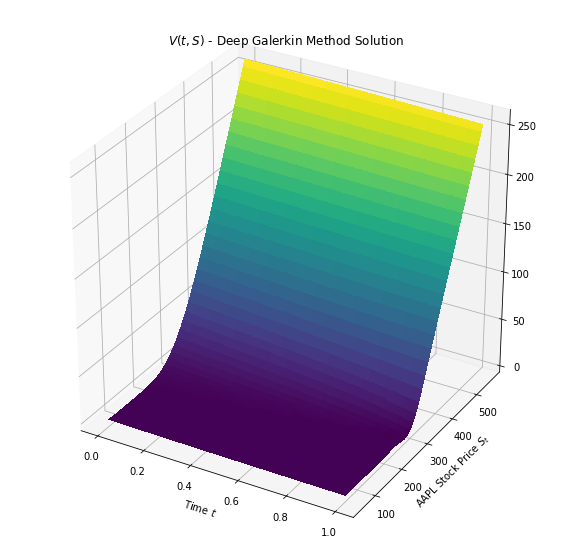

In [19]:
t_grid = call_option.t.numpy().reshape((365, 365))
s_grid = call_option.s.numpy().reshape((365, 365))
V_hat = tf.reshape(AAPL_call, (365, 365))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('$V(t, S)$ - Deep Galerkin Method Solution')

s = ax.plot_surface(t_grid, 
                    s_grid,
                    V_hat,
                    linewidth=0,
                    antialiased=False,
                    cmap=cm.viridis)

ax.set_xlabel('Time $t$')
ax.set_ylabel('AAPL Stock Price $S_t$');

The estimated AAPL option price today for an american call with expiry in one year and strike $307.714:

In [43]:
t0, s0 = tf.constant(0.0, shape=(1, 1)), tf.constant(s_market, shape=(1, 1))
AAPL_call_1year = call_model(t0, s0)
print("V(0, S_0) = {}".format(AAPL_call_1year.numpy()[0, 0]))

V(0, S_0) = 17.138694763183594


Using [this](https://www.cboe.com/framed/IVolframed.aspx?content=https%3a%2f%2fcboe.ivolatility.com%2fcalc%2findex.j%3fcontract%3d18589082-4C36-4C27-9F3A-4AB06BF92FB6&sectionName=SEC_TRADING_TOOLS&title=CBOE%20-%20IVolatility%20Services) option price calculator with the same parameters, the estimated price is $17.1940. The pricing method used by this calculator is not known, but nonetheless our result is quite close.

### Saving the weights

In [44]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
call_model.save_weights('drive/My Drive/Colab Notebooks/models/DGM_aapl_call.hf5')